# Title/Salary Key Term Associations

This is a small bit of personal exploration into associations between key terms mentioned in data science job titles and the estimated salaries provided by employers and by glassdoor. Especially for new data scientists looking for their first job, its potentially useful to know how much employers are looking to pay to fill these positions, while at the same time a lack of experience makes it difficult to know what to expect.

Using a mixture of basic data processing and visualization skills, knowledge of inferential statistics, and some basic natural language processing, the analysis below can give a broad understanding of how the terms used in job postings often affect the salary expectations, as well as some idea of how experience factors into the overall equation of how much a data scientist makes.

Data Science Jobs dataset from glassdoor (accessed via kaggle): https://www.kaggle.com/datasets/georgejnr/advertised-data-science-jobs-dataset?resource=download

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy
import numpy as np
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.probability import FreqDist
import string

### Initial Loading of Data and EDA

In [2]:
#Loading Data
ds_jobs = pd.read_csv("./data_sci_jobs.csv")
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ",$70K - $79K (Employer est.)
1,Paliwoda Group,"Junior Researcher, Data Science","New York, NY",NaN
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY",$26.45 Per Hour(Employer est.)
3,Discord,Data Engineering Manager,"San Francisco, CA",$192K (Employer est.)
4,YT Global Network,Data Engineer- Remote,Remote,$90.00 - $120.00 Per Hour(Employer est.)
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA",$109K - $142K (Employer est.)
2426,pulseData,Data Science Associate (Remote),"New York, NY",$50K - $83K (Glassdoor est.)
2427,Bayer,NAFTO Data Science Co-op,United States,$35.00 Per Hour(Employer est.)
2428,MediaMath,"VP, Data Science","New York, NY",$231K - $300K (Employer est.)


In [3]:
#check for nulls in job title and estimated salary
print(ds_jobs["Job Title"].isna().sum())
print(ds_jobs["Estimated Salary"].isna().sum())

0
482


In [4]:
#drop null salary jobs
ds_jobs.dropna(subset=["Estimated Salary"], inplace=True)
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ",$70K - $79K (Employer est.)
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY",$26.45 Per Hour(Employer est.)
3,Discord,Data Engineering Manager,"San Francisco, CA",$192K (Employer est.)
4,YT Global Network,Data Engineer- Remote,Remote,$90.00 - $120.00 Per Hour(Employer est.)
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,$45.00 - $50.00 Per Hour(Employer est.)
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA",$109K - $142K (Employer est.)
2426,pulseData,Data Science Associate (Remote),"New York, NY",$50K - $83K (Glassdoor est.)
2427,Bayer,NAFTO Data Science Co-op,United States,$35.00 Per Hour(Employer est.)
2428,MediaMath,"VP, Data Science","New York, NY",$231K - $300K (Employer est.)


### Convert Salaries to Numeric Data Type / Clean Data and Standardize Units

In [5]:
#remove estimate provider statement from salaries
ds_jobs["Estimated Salary"] = ds_jobs["Estimated Salary"].map(lambda s: re.sub("\(.*?\)", "", s))
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ",$70K - $79K
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY",$26.45 Per Hour
3,Discord,Data Engineering Manager,"San Francisco, CA",$192K
4,YT Global Network,Data Engineer- Remote,Remote,$90.00 - $120.00 Per Hour
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,$45.00 - $50.00 Per Hour
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA",$109K - $142K
2426,pulseData,Data Science Associate (Remote),"New York, NY",$50K - $83K
2427,Bayer,NAFTO Data Science Co-op,United States,$35.00 Per Hour
2428,MediaMath,"VP, Data Science","New York, NY",$231K - $300K


In [6]:
#convert suffix K to thousands of dollars
ds_jobs["Estimated Salary"] = ds_jobs["Estimated Salary"].map(lambda s: s.replace("K", "000"))
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ",$70000 - $79000
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY",$26.45 Per Hour
3,Discord,Data Engineering Manager,"San Francisco, CA",$192000
4,YT Global Network,Data Engineer- Remote,Remote,$90.00 - $120.00 Per Hour
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,$45.00 - $50.00 Per Hour
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA",$109000 - $142000
2426,pulseData,Data Science Associate (Remote),"New York, NY",$50000 - $83000
2427,Bayer,NAFTO Data Science Co-op,United States,$35.00 Per Hour
2428,MediaMath,"VP, Data Science","New York, NY",$231000 - $300000


In [7]:
#convert per hour to annual salary based on assumption of 40-hour workweek 
def annual_calc(num):
    """simple helper function for unit conversion from hourly to annual salary"""
    annual = num*40*52
    return annual

def hourly_conversion(string):
    """Converts hourly salaries and salary ranges to annual equivalents based on a 40-hour workweek.
    Note that this assumes holidays and PTO are paid at normal rate and no additional hours are worked.
    
    ***Arguments***
    string: individual input strings from the salary column. Assesses string for hourly units. If 
            string represents hourly units, the string is parsed to obtain numeric representation for 
            hourly salary or salary ranges and calculates annual salary equivalent
            
    ***Returns***
    function returns annual salary equivalents as a numeric string (for consistency with raw salary 
    ranges remaining in the data)
    """
    #convert on conditional
    if "Per Hour" in string:
        string.replace("Per Hour", "")
        substrings = re.findall("\d+", string)
        substrings = [annual_calc(int(s)) for s in substrings]
        #remove extra strings due to decimal
        substrings = [s for s in substrings if s!=0]
        #joining converted salaries
        new_string = ""
        for i in substrings:
            new_string += f" {i} -"
        return new_string[1:-1]
    
    #if not hourly salary, return string unchanged
    else:
        return string

#conversion
ds_jobs["Estimated Salary"] = ds_jobs["Estimated Salary"].apply(hourly_conversion)
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ",$70000 - $79000
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY",54080 - 93600
3,Discord,Data Engineering Manager,"San Francisco, CA",$192000
4,YT Global Network,Data Engineer- Remote,Remote,187200 - 249600
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,93600 - 104000
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA",$109000 - $142000
2426,pulseData,Data Science Associate (Remote),"New York, NY",$50000 - $83000
2427,Bayer,NAFTO Data Science Co-op,United States,72800
2428,MediaMath,"VP, Data Science","New York, NY",$231000 - $300000


In [8]:
#convert listed salaries and salary ranges to 3 columns: upper bound, median, and lower bound
#if range is provided, median value fills the median column
#if specific salary is provided, a 20% over/under tolerance formula is used to estimate upper/lower

def salary(string):
    """Helper function to ingest strings from estimated salary column and convert them to 
    upper bound, median, and lower bound values. Returns these numbers as a list of integers"""
    
    substrings = re.findall("\d+", string)
    salary_bounds = []
    #specific salary
    if len(substrings)==1:
        salary_bounds.append(int(substrings[0]))
        upper = salary_bounds[0]*1.2
        lower = salary_bounds[0]*0.8
        salary_bounds.append(upper)
        salary_bounds.append(lower)
        salary_bounds.sort()
    #salary range
    else:
        for i in substrings:
            salary_bounds.append(int(i))
        salary_bounds.sort()
        lower = salary_bounds[0]
        upper = salary_bounds[-1]
        median = (upper+lower)/2
        salary_bounds.append(median)
        salary_bounds.sort()
    
    return salary_bounds

#obtain salary ranges and medians
ds_jobs["Estimated Salary"] = ds_jobs["Estimated Salary"].apply(salary)
ds_jobs

,Company,Job Title,Location,Estimated Salary
0,Dataquestcorp,Data Science,"Branchburg, NJ","[70000, 74500.0, 79000]"
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY","[54080, 73840.0, 93600]"
3,Discord,Data Engineering Manager,"San Francisco, CA","[153600.0, 192000, 230400.0]"
4,YT Global Network,Data Engineer- Remote,Remote,"[187200, 218400.0, 249600]"
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,"[93600, 98800.0, 104000]"
...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA","[109000, 125500.0, 142000]"
2426,pulseData,Data Science Associate (Remote),"New York, NY","[50000, 66500.0, 83000]"
2427,Bayer,NAFTO Data Science Co-op,United States,"[58240.0, 72800, 87360.0]"
2428,MediaMath,"VP, Data Science","New York, NY","[231000, 265500.0, 300000]"


In [9]:
#split salary range and median values into columns
split_sal = pd.DataFrame(ds_jobs["Estimated Salary"].to_list(), 
                         columns=["Lower Bound", 
                                  "Median",
                                  "Upper Bound"],
                         index=ds_jobs.index
                        )
#rejoin tables
ds_jobs = ds_jobs.join(split_sal)
ds_jobs

,Company,Job Title,Location,Estimated Salary,Lower Bound,Median,Upper Bound
0,Dataquestcorp,Data Science,"Branchburg, NJ","[70000, 74500.0, 79000]",70000.0,74500.0,79000.0
2,"JPMorgan Chase Bank, N.A.",2023 Advancing Hispanics & Latinos Fellowship ...,"New York, NY","[54080, 73840.0, 93600]",54080.0,73840.0,93600.0
3,Discord,Data Engineering Manager,"San Francisco, CA","[153600.0, 192000, 230400.0]",153600.0,192000.0,230400.0
4,YT Global Network,Data Engineer- Remote,Remote,"[187200, 218400.0, 249600]",187200.0,218400.0,249600.0
5,excelon solutuion,Hiring for Data Science and AWS on w2,Remote,"[93600, 98800.0, 104000]",93600.0,98800.0,104000.0
...,...,...,...,...,...,...,...
2425,C3 AI,Data Science Instructor,"Redwood City, CA","[109000, 125500.0, 142000]",109000.0,125500.0,142000.0
2426,pulseData,Data Science Associate (Remote),"New York, NY","[50000, 66500.0, 83000]",50000.0,66500.0,83000.0
2427,Bayer,NAFTO Data Science Co-op,United States,"[58240.0, 72800, 87360.0]",58240.0,72800.0,87360.0
2428,MediaMath,"VP, Data Science","New York, NY","[231000, 265500.0, 300000]",231000.0,265500.0,300000.0


### Natural Language Processing of Job Titles

In [10]:
#tokenize terms in job title
ds_jobs["Job Title"] = ds_jobs["Job Title"].apply(word_tokenize)
ds_jobs

,Company,Job Title,Location,Estimated Salary,Lower Bound,Median,Upper Bound
0,Dataquestcorp,"[Data, Science]","Branchburg, NJ","[70000, 74500.0, 79000]",70000.0,74500.0,79000.0
2,"JPMorgan Chase Bank, N.A.","[2023, Advancing, Hispanics, &, Latinos, Fello...","New York, NY","[54080, 73840.0, 93600]",54080.0,73840.0,93600.0
3,Discord,"[Data, Engineering, Manager]","San Francisco, CA","[153600.0, 192000, 230400.0]",153600.0,192000.0,230400.0
4,YT Global Network,"[Data, Engineer-, Remote]",Remote,"[187200, 218400.0, 249600]",187200.0,218400.0,249600.0
5,excelon solutuion,"[Hiring, for, Data, Science, and, AWS, on, w2]",Remote,"[93600, 98800.0, 104000]",93600.0,98800.0,104000.0
...,...,...,...,...,...,...,...
2425,C3 AI,"[Data, Science, Instructor]","Redwood City, CA","[109000, 125500.0, 142000]",109000.0,125500.0,142000.0
2426,pulseData,"[Data, Science, Associate, (, Remote, )]","New York, NY","[50000, 66500.0, 83000]",50000.0,66500.0,83000.0
2427,Bayer,"[NAFTO, Data, Science, Co-op]",United States,"[58240.0, 72800, 87360.0]",58240.0,72800.0,87360.0
2428,MediaMath,"[VP, ,, Data, Science]","New York, NY","[231000, 265500.0, 300000]",231000.0,265500.0,300000.0


In [11]:
#nlp pre-processing
def manual_clean(key_terms):
    """Helper function to ingest list of strings and clean the terms for analysis"""
    #remove capitalization
    step_1 = [t.lower() for t in key_terms]
    #remove punctuation
    step_2 = [term.translate(str.maketrans('','',string.punctuation)) for term in step_1]
    #remove numerics
    step_3 = [term.translate(str.maketrans('','',"1234567890")) for term in step_2]   
    #remove empty strings, stop words, and "data" which is a search term providing no semantic value
    step_4 = [t for t in step_3 if t!='']
    step_5 = [t for t in step_4 if t not in stopwords.words("english")]
    cleaned_key_terms = [t for t in step_5 if t!="data"]
    
    #function output
    return cleaned_key_terms
    
ds_jobs["Job Title"] = ds_jobs["Job Title"].apply(manual_clean)
ds_jobs

,Company,Job Title,Location,Estimated Salary,Lower Bound,Median,Upper Bound
0,Dataquestcorp,[science],"Branchburg, NJ","[70000, 74500.0, 79000]",70000.0,74500.0,79000.0
2,"JPMorgan Chase Bank, N.A.","[advancing, hispanics, latinos, fellowship, pr...","New York, NY","[54080, 73840.0, 93600]",54080.0,73840.0,93600.0
3,Discord,"[engineering, manager]","San Francisco, CA","[153600.0, 192000, 230400.0]",153600.0,192000.0,230400.0
4,YT Global Network,"[engineer, remote]",Remote,"[187200, 218400.0, 249600]",187200.0,218400.0,249600.0
5,excelon solutuion,"[hiring, science, aws, w]",Remote,"[93600, 98800.0, 104000]",93600.0,98800.0,104000.0
...,...,...,...,...,...,...,...
2425,C3 AI,"[science, instructor]","Redwood City, CA","[109000, 125500.0, 142000]",109000.0,125500.0,142000.0
2426,pulseData,"[science, associate, remote]","New York, NY","[50000, 66500.0, 83000]",50000.0,66500.0,83000.0
2427,Bayer,"[nafto, science, coop]",United States,"[58240.0, 72800, 87360.0]",58240.0,72800.0,87360.0
2428,MediaMath,"[vp, science]","New York, NY","[231000, 265500.0, 300000]",231000.0,265500.0,300000.0


In [ ]:
#save processed data for later
#ds_jobs.to_csv("./data_sci_jobs_pre_processed.csv")

### Vectorizing the Key Terms

In [ ]:
#ds_jobs = pd.read_csv("./data_sci_jobs_pre_processed.csv")

In [12]:
#defining helper function for converting part of speech tags in next cell
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
#lemmatizing terms to obtain roots
def lem(terms):
    """helper function to apply lemmatization to pandas series"""
    #tag part of speech
    tagged = pos_tag(terms)
    #convert POS tags using helper function above
    tagged_lem = [(t[0], get_wordnet_pos(t[1])) for t in tagged]
    #lemmatize
    lemma = nltk.stem.WordNetLemmatizer()
    lemmed = [lemma.lemmatize(t[0],t[1]) for t in tagged_lem]
    #output
    return lemmed

#apply to dataframe
ds_jobs["Job Title"] = ds_jobs["Job Title"].apply(lem)
ds_jobs

,Company,Job Title,Location,Estimated Salary,Lower Bound,Median,Upper Bound
0,Dataquestcorp,[science],"Branchburg, NJ","[70000, 74500.0, 79000]",70000.0,74500.0,79000.0
2,"JPMorgan Chase Bank, N.A.","[advance, hispanic, latinos, fellowship, progr...","New York, NY","[54080, 73840.0, 93600]",54080.0,73840.0,93600.0
3,Discord,"[engineering, manager]","San Francisco, CA","[153600.0, 192000, 230400.0]",153600.0,192000.0,230400.0
4,YT Global Network,"[engineer, remote]",Remote,"[187200, 218400.0, 249600]",187200.0,218400.0,249600.0
5,excelon solutuion,"[hire, science, aws, w]",Remote,"[93600, 98800.0, 104000]",93600.0,98800.0,104000.0
...,...,...,...,...,...,...,...
2425,C3 AI,"[science, instructor]","Redwood City, CA","[109000, 125500.0, 142000]",109000.0,125500.0,142000.0
2426,pulseData,"[science, associate, remote]","New York, NY","[50000, 66500.0, 83000]",50000.0,66500.0,83000.0
2427,Bayer,"[nafto, science, coop]",United States,"[58240.0, 72800, 87360.0]",58240.0,72800.0,87360.0
2428,MediaMath,"[vp, science]","New York, NY","[231000, 265500.0, 300000]",231000.0,265500.0,300000.0


In [14]:
#dropping unnecessary info before vectorizing Job Title terms
ds_jobs_vect = ds_jobs.drop(labels=["Company", "Location", "Estimated Salary"], axis=1)
ds_jobs_vect

,Job Title,Lower Bound,Median,Upper Bound
0,[science],70000.0,74500.0,79000.0
2,"[advance, hispanic, latinos, fellowship, progr...",54080.0,73840.0,93600.0
3,"[engineering, manager]",153600.0,192000.0,230400.0
4,"[engineer, remote]",187200.0,218400.0,249600.0
5,"[hire, science, aws, w]",93600.0,98800.0,104000.0
...,...,...,...,...
2425,"[science, instructor]",109000.0,125500.0,142000.0
2426,"[science, associate, remote]",50000.0,66500.0,83000.0
2427,"[nafto, science, coop]",58240.0,72800.0,87360.0
2428,"[vp, science]",231000.0,265500.0,300000.0


In [15]:
#vectorization

#dummy tokenizer and preprocessor since we already tokenized
def dummy(doc):
    return doc

count_vect = CountVectorizer(
    analyzer='word',
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None) 
X = count_vect.fit_transform(list(ds_jobs_vect["Job Title"]))

#get vectorized terms and concatenate dataframes
tf_df = pd.DataFrame(X.toarray(), columns=count_vect.get_feature_names_out(), index=ds_jobs_vect.index)
ds_jobs_vect = ds_jobs_vect.join(tf_df)
ds_jobs_vect

,Job Title,Lower Bound,Median,Upper Bound,advance,ai,aiml,analyst,analytics,associate,...,safety,science,scientist,software,solution,team,track,visualizer,vp,w
0,[science],70000.0,74500.0,79000.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"[advance, hispanic, latinos, fellowship, progr...",54080.0,73840.0,93600.0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,"[engineering, manager]",153600.0,192000.0,230400.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[engineer, remote]",187200.0,218400.0,249600.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"[hire, science, aws, w]",93600.0,98800.0,104000.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,"[science, instructor]",109000.0,125500.0,142000.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2426,"[science, associate, remote]",50000.0,66500.0,83000.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2427,"[nafto, science, coop]",58240.0,72800.0,87360.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2428,"[vp, science]",231000.0,265500.0,300000.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [16]:
#terms in our job titles
count_vect.vocabulary_

{'science': 42,
 'advance': 0,
 'hispanic': 26,
 'latinos': 30,
 'fellowship': 19,
 'program': 38,
 'ai': 1,
 'track': 47,
 'engineering': 15,
 'manager': 31,
 'engineer': 14,
 'remote': 39,
 'hire': 25,
 'aws': 6,
 'w': 50,
 'visualizer': 48,
 'earth': 13,
 'coop': 10,
 'flight': 20,
 'safety': 41,
 'fall': 16,
 'graduate': 23,
 'scientist': 43,
 'aiml': 2,
 'junior': 29,
 'fellow': 18,
 'decision': 12,
 'july': 28,
 'december': 11,
 'consultant': 9,
 'analyst': 3,
 'pipeline': 36,
 'operator': 34,
 'software': 44,
 'instructor': 27,
 'associate': 5,
 'nafto': 32,
 'vp': 49,
 'head': 24,
 'postdoctoral': 37,
 'researcher': 40,
 'focused': 21,
 'analytics': 4,
 'solution': 45,
 'team': 46,
 'fast': 17,
 'fulltime': 22,
 'black': 7,
 'pathway': 35,
 'chase': 8,
 'operation': 33}

### Data Visualization and Clustering

Note: Since the lemmatization by NLTK did not address some items such as "engineer" vs "engineering", it appears we will have to account for these issues in our analysis separately.

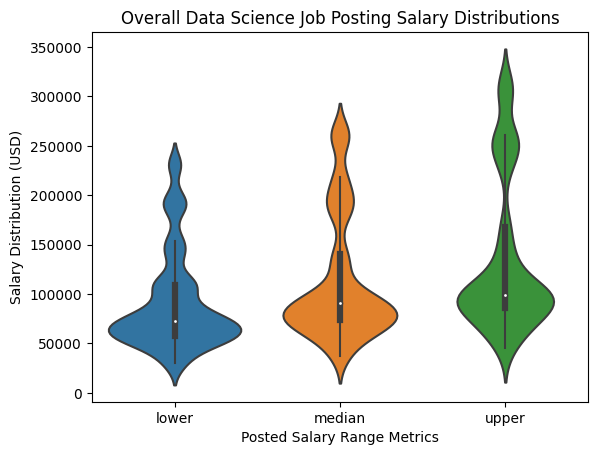

In [28]:
#violin plot looking at overall upper, mid, and lower salary spreads for all data science positions
#configuring data for plot
lower_b = [(x, "lower") for x in ds_jobs_vect["Lower Bound"]]
mid = [(x, "median") for x in ds_jobs_vect["Median"]]
upper = [(x, "upper") for x in ds_jobs_vect["Upper Bound"]]
dist_table = lower_b + mid + upper
df = pd.DataFrame(dist_table)

#violin plot
ax = sns.violinplot(x=df[1],y=df[0])
ax.set_title("Overall Data Science Job Posting Salary Distributions")
ax.set_xlabel("Posted Salary Range Metrics")
ax.set_ylabel("Salary Distribution (USD)")
plt.show()